In [ ]:
!pip install scipy
!pip install pandas
!pip install numpy
!pip install scikit-learn
!pip install seaborn

## Поиск выбросов (outlier detection) и аномалий в данных

Выброс - такой объект в признаке, который отличается от остальных (очень странные значения, не похожие на другие). Но в тоже время, является **реально сущесвутющим** объектом.

Так как, он является корректным значением (не пустым, не опечаткой), то влечет иной способ обработки. С прошлыми случаями мы поступали так - заменяли на среднее, медиану, КК, расстояния, регрессию, итп.

Поступают с ними очень жестко - как только вы нашли выброс, то **безжалостно удаляем**

Зачем нужно искать и удалять выбросы:
- если задачей является предсказывание, то удаление выброса то как правило увеличивает точность.
- получаем типичные данные
- большинство статистических характеристик очень чувствительны к выбросам (если посчитаем зарплату сотрудников компании Рога и Копыта, то получим вполне себе среднюю зарплату, но если в выборку добавим топ менеджет гугла, то средняя зарплата перестанет быть адекватной)

Несколько слов о выбросах:
- математического определения выброса **не существует!**, кроме того, каждый алгоритм/человек/что-то еще имеет свой способ определения что же такое этот выброс. Исходя из этого, сложно провести конкретно четкую границу между нормой и аномалией
- "жетский" способ удаления выбросов будет удалять и часть типичных (нормальных) объектов
- "мягкий " способ удаления выбросов будет оставлять и выбросы

То есть, идеального и строго определенного подхода к выбросам - **не существует!**


Как искать:
- смысловая нагрузка признака. Мы знаем, что типичный рост человека где-то в дапозоне $ [140,200](см) $, тогда как 250см тоже существует, но является выбросом
- методы основанные на анализе одного признака (каждый признак анализируется отдельно)
- методы основанные на анализе сразу нескольких признаков

Вывод:
- наличие выбросов ухудшает качество ML моделей
- сложно формально определить, что такое выброс
- нетипичные значения в генеральной совокупности - есть выброс


### Простейшие идеи поиска выбросов

$X = (x_1, x_2, ..., x_n)$

$\bar X$ - среднее

$n$ - размер выборки

$S_x$ - отклонение

Идея - найти все объекты, которые слишком далеко от среднего (медианы, другой метрики):
1. удалить те объекты, у которых $|x_1 - \bar x|$ далеко
2. удалить те объекты, у которых ${|x_1 - \bar x|} \over S_x$ далеко
3. критерий Шовене
4. без использования среднего и отклонения


#### Пример алгоритма идеи 2

1. a - подозреваемый на выброс
2. уберем a из выборки и вычислим среднее и отклонение без него
3. если выборка является симметричной (см lec03), то x является выбросом, если не принадлежит $(\bar X - 3S_x, \bar X + 3S_x)$
4. если не симметрична, то то x является выбросом, если не принадлежит $(\bar X - 5S_x, \bar X + 5S_x)$

#### Критерий Шовене (Chauvenet)

Более продвинутый способ поиска выброса - критерий шовене

Суть:
значение $x_i$ будет выбросом, если выполнено неравенство $erfc({|x_i - \bar x| \over S_x}) < {1 \over 2n} $ 

[erfc](https://ru.wikipedia.org/wiki/%D0%A4%D1%83%D0%BD%D0%BA%D1%86%D0%B8%D1%8F_%D0%BE%D1%88%D0%B8%D0%B1%D0%BE%D0%BA) - дополнительная функция ошибок. C возврастанием аргумента функция стримится к нулю. То есть, если подставить в неравенство слишком больше число, то значение будет выбросом.

функцию можно использовать многократно. 

In [19]:
from scipy.special import erfc
import numpy as np
import scipy.stats as st

arr = np.array([3,5,8,15,100,32,126,384])

def chauvenet(y: np.array, mean=None, stdv=None) -> np.array:
    # based on https://github.com/msproteomicstools/msproteomicstools/blob/master/msproteomicstoolslib/math/chauvenet.py
    '''
        Returns: np.array[bool]. if false, then outlier
    '''
    if mean is None:
        mean = y.mean()    # Mean of incoming array y
    if stdv is None:
        stdv = y.std()      # Its standard deviation

    abs_deviation = np.abs(y - mean) / stdv
    d = erfc(abs_deviation)
    # Calculate the maximum absolute deviation that is still acceptable according to Chauvenet's criterion
    threshold = 1 / (2 * y.size - 1)

    # Determine which data points are outliers
    is_outlier = d > threshold

    # Return the indices of the outliers
    return is_outlier

train = np.array([1,2,3,4,5,6,7,8, 100 ])


mean = train.mean()
stdv = train.std()

def iterate(sample: np.array, repeat: bool = True) -> np.array:
    test_result = chauvenet(sample, mean, stdv)
    repeat = np.any(test_result == False)
    
    print('sample: ', sample)
    print('test_result: ', test_result)
    print('-----')
    
    if repeat:
        return iterate(sample[test_result], repeat)
    
    return sample
    
print(iterate(sample=train))

sample:  [  1   2   3   4   5   6   7   8 100]
test_result:  [ True  True  True  True  True  True  True  True False]
-----
sample:  [1 2 3 4 5 6 7 8]
test_result:  [ True  True  True  True  True  True  True  True]
-----
[1 2 3 4 5 6 7 8]


#### Поиск без среднего и отклонения

Использование среднего и отклонения приводит к проблемам (которые рассматривались ранее), так как эти метрики сильно чувствительны к выбросам.

Возникает идея, использовать методы, основанные на более устойчивых метриках

##### Квартили

$Q_{25}$ - такое число, что 25% выборки меньше 

$Q_{50}$ - Такое число, что 50% выборки меньше

$Q_{75}$ - такое число, что 75% выборки меньше 

Как считаем?
1) Соортируем и ищем медиану - получаем $Q_{50}$
2) Делим выборку на 2 части, left - меньше медианы, right - больше медианы
3) Ищем медиану внутри этих выборок, получаем $Q_{25}$ из left, $Q_{75}$ из right

Как использовать для поиска аномалий?

Фактически, 50% выборки лежит в интервале $[Q_{25}, Q_{75}]$, тогда элементы, которые сильно далеки от $Q_{25}$, $Q_{75}$ этого интервала, считаем выбросами.

Правило: Если элемент не попадает в интервал $(Q_{25} - 1.5*(Q_{75} - Q_{25}), Q_{75} + 1.5*(Q_{75} - Q_{25}))$, то элемент есть выброс

P.S. на этом и основан boxplot

### Методы основанные на нескольких признаках

Недостатки методов, основанные на одном признаке

1) Представим выборку $(1,100,1,100,1,100, 30, 30, 30, 100,1, 100, 30, 50)$, 50 очевидно выброс, но ни один из методов анализа одного признака не сможет его отловить

2) Аномалии могут характеризоваться не только экстримальными значениями одного признака, но и комбинацией нескольких признаков (визульно можно посмотреть при помощи scatter). Например, рост 180см и вес 30кг

Какие идеи могут помочь?
1) метрические методы (расстояние от объекта, до его ближайших соседей очень большое)
2) геометрические методы
3) кластеризация (обучение без учителя). Например, если объект попадает в слишком маленький кластер, то вероятно это выброс
4) модели машинного обучения, различные вариациии decision trees, некоторые SVM
5) использовать предсказание признака по другим признакам, объекты для которых предсказание предсказание сильно разнится, можно объявить выбросом. **Но скорее всего, такой алгоритм не даст нормального результата, нужно быть с этим аккуратнее. Такое можно использовать, когда мы четко понимаем, что это зависимые величины**

[*дополнительно почитать](http://data4.ru/anomalydetection)

In [20]:
import numpy as np

def to_pairs(arr1, arr2):
    return np.vstack((arr1, arr2)).T

def standard_scale(X):
    mean = np.mean(X, axis=0)
    std = np.std(X, axis=0)

    # Normalize the data
    X_norm = (X - mean) / std
    
    return X_norm

<AxesSubplot:>

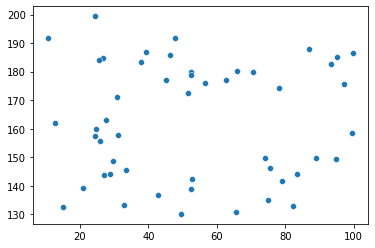

In [21]:
import seaborn as sns
import numpy as np

%matplotlib inline

np.random.seed(54)

weight = np.random.uniform(low=10, high=100, size=(50,))
# sam
height = np.random.uniform(low=130, high=200, size=(50,))

sns.scatterplot(x=weight, y=height) # видим, , что точки выше 190 и с маленьким весом вероятно являются выбросами

Для примера рассмотрим метод [кластеризации основанный на плотности](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html), более детально методы обучения без учителя будет изучать далее.

У данного метода есть 2 обязтаельных параметра:
- EPS: Максимальное расстояние между двумя точками, при котором точка считается соседним с другой. Это самый важный параметр DBSCAN, который следует правильно выбрать для вашего набора данных и функции расстояния. (про то, как выбирать EPS поговорим в следующих лекциях)
- min_samples: минимальное количетсов точек в кластере


dots labels:  [0, 1, 2, 3, 4, 5, 6, 7, 3, 8, 3, 9, 10, 11, 12, 13, 9, 14, 6, 13, 9, 2, 15, 15, 3, 16, 3, 15, 17, 3, 18, 19, 15, 11, 11, 16, 10, 20, 10, 3, 21, 22, 10, 15, 13, 3, 11, 23, 23, 24]


<AxesSubplot:>

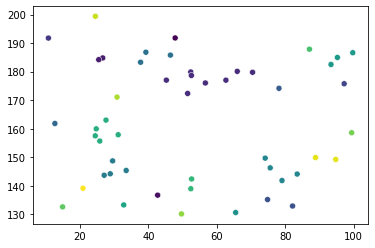

In [22]:
from sklearn.cluster import DBSCAN

X = to_pairs(weight, height) # превращаем вес, рост в пары
X_norm = standard_scale(X) # используем стандартизацию

# ВАЖНО! на обучение отдаем нормированные данные!
clustering = DBSCAN(eps=0.3, min_samples=1).fit(X_norm) # обучаем модель, сейчас EPS была выбрана случайным образом

x_labels = clustering.labels_ # получаем отношение точек к кластеру
print('dots labels: ', list(x_labels))
sns.scatterplot(x=weight, y=height, c=clustering.labels_)


Points to leave = False: [False, False, False, True, False, False, False, False, True, False, True, True, True, True, False, True, True, False, False, True, True, False, True, True, True, False, True, True, False, True, False, False, True, True, True, False, True, False, True, True, False, False, True, True, True, True, True, False, False, False]

 Как видим из результата, выборка стала более стабильной 


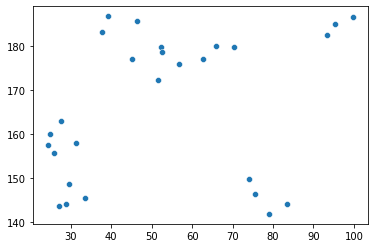

In [23]:
from collections import Counter
# Далее говорим, что выбросами являются те точки, у которых расстояние до других точек слишком больше (мы это видим, по количеству точек в кластерах)
labels_counter = Counter(x_labels) 

# далее дропаем те, у которых только меньше двух точек в кластере

filter_dots = np.array([labels_counter[label] > 2 for label in x_labels])

print('Points to leave = False:', list(filter_dots))

X_filtered = X[filter_dots]
height_filtered =  X_filtered[:, 1]
weight_filttered = X_filtered[:, 0]

sns.scatterplot(x=weight_filttered, y=height_filtered)
print('\n', 'Как видим из результата, выборка стала более стабильной ')

## Гипотезы и статистическая значимость

Гипотеза - это предположение, которое делается на основе доступных данных, для того чтобы проверить ее на согласованность с фактическими данными или выявить возможные закономерности. Гипотеза обычно формулируется в виде утверждения о взаимосвязи между двумя или более переменными. Например, гипотеза может быть о том, что наличие специального диетического режима улучшает здоровье пациентов с определенным заболеванием.

Статистическая значимость - это вероятность того, что различия между двумя группами или результаты исследования случайны и не могут быть объяснены только случайными факторами. Таким образом, статистическая значимость указывает на то, что различия между группами или результаты исследования настолько большие, что они не могут быть объяснены случайностью и, следовательно, они имеют реальное значение. Оценка статистической значимости обычно выполняется при помощи статистических тестов, которые позволяют определить вероятность того, что различия между группами являются статистически значимыми.

Проверка гипотез используется для проверки обоснованности утверждения (нулевой гипотезы), сделанного в отношении совокупности с использованием выборочных данных. Альтернативная гипотеза — это та, в которую вы бы поверили, если бы нулевая гипотеза оказалась неверной.

Символьные обозначения:
- $H_0$ - (нулевая гипотеза) разница не является статистически значимой, т. е. наблюдаемые данные могут происходят из ожидаемого распределения.
- $H_1$ - (альтернативная гипотеза) разница является статистически значимой, т. е. наблюдаемые данные не могут происходят из ожидаемого распределения.

**Если по простому**

Значимость переменной будет доказана, если мы опровергнем $H_0$ и ~примем~ (на самом деле никогда не используем оборот, что гипотеза является принятой, более правильным подходом называть данные состояние - не опровергнем) альтернативную гипотезу $H_1$

*[Изучить более подробно](https://agricolamz.github.io/DS_for_DH/%D0%BF%D1%80%D0%BE%D0%B2%D0%B5%D1%80%D0%BA%D0%B0-%D1%81%D1%82%D0%B0%D1%82%D0%B8%D1%81%D1%82%D0%B8%D1%87%D0%B5%D1%81%D0%BA%D0%B8%D1%85-%D0%B3%D0%B8%D0%BF%D0%BE%D1%82%D0%B5%D0%B7.html)

### P-value

P-value - это вероятность получить такие же или более экстремальные результаты, чем наблюдаемые в эксперименте, при условии, что нулевая гипотеза верна.

Нулевая гипотеза - это общепринятая теория или утверждение, которое мы пытаемся опровергнуть или подтвердить в ходе эксперимента.

Например, мы можем провести эксперимент, чтобы проверить, есть ли различия в среднем росте мужчин и женщин. Нулевая гипотеза в данном случае может звучать так: "Средний рост мужчин и женщин одинаковый".

P-value рассчитывается путем определения статистической значимости между двумя выборками. Это делается с помощью статистических методов, таких как t-тест, ANOVA, корреляция Пирсона и другие.

После того, как статистическая значимость рассчитана, P-value вычисляется путем определения, насколько вероятно, что мы получили наши наблюдаемые данные при условии, что нулевая гипотеза верна.

Например, если мы получили P-value $>=$ 0.05 , это означает, что при условии, что нулевая гипотеза верна, есть 5% вероятность получить такие же или более экстремальные результаты, чем наблюдаемые в эксперименте.

Чем меньше P-value, тем меньше вероятность получить такие же или более экстремальные результаты при условии, что нулевая гипотеза верна, и тем более убедительными будут наши данные для отвержения нулевой гипотезы. Обычно установлен порог P-value в 0.05 или 0.01, что означает, что если P-value меньше этого порога, мы можем считать результаты статистически значимыми и отвергнуть нулевую гипотезу.

<img src='https://imgs.xkcd.com/comics/p_values.png' />

**Если по простому**

Когда P-value ниже порога (обычно 0.05, но иногда берут и 0.01 - например в медицинских данных), то это значит, что различия значимы и нам стоит использовать этот признак для дальнейшего исследования данных.

Следующие методы рассматривают более глобальную и сложную тему **Feature Selection**, с которой более глубже мы познакомимся позже.

### Классификация статистических тестов

* материал взят с [https://agricolamz.github.io/](https://agricolamz.github.io/DS_for_DH/%D0%BF%D1%80%D0%BE%D0%B2%D0%B5%D1%80%D0%BA%D0%B0-%D1%81%D1%82%D0%B0%D1%82%D0%B8%D1%81%D1%82%D0%B8%D1%87%D0%B5%D1%81%D0%BA%D0%B8%D1%85-%D0%B3%D0%B8%D0%BF%D0%BE%D1%82%D0%B5%D0%B7.html)

#### Классификация по количеству выборок

- Одновыборочные тесты (one-sample tests) - используются для проверки гипотезы о среднем значении выборки относительно известного значения или для сравнения выборочного среднего с теоретическим значением.

<img src="https://agricolamz.github.io/DS_for_DH/DS_for_DH_files/figure-html/unnamed-chunk-509-1.png" width=400 />

- Двухвыборочные тесты (two-sample tests) - используются для сравнения средних значений двух независимых выборок, чтобы определить, являются ли они статистически значимо различными.

<img src="https://agricolamz.github.io/DS_for_DH/DS_for_DH_files/figure-html/unnamed-chunk-510-1.png" width=400 />

- Многовыборочные тесты (multiple-sample tests) - используются для сравнения средних значений более чем двух независимых выборок.

<img src="https://agricolamz.github.io/DS_for_DH/DS_for_DH_files/figure-html/unnamed-chunk-511-1.png" width=400 />

#### Классификация по направлению

- Односторонние тесты проверяют гипотезу только в одном направлении, то есть они определяют, являются ли данные больше или меньше определенного значения. Например, односторонний тест может проверять гипотезу о том, что новый лекарственный препарат лучше, чем старый.

- Двухсторонние тесты, наоборот, проверяют гипотезу в обоих направлениях, то есть они определяют, отличаются ли данные от определенного значения в любом направлении. Например, двухсторонний тест может проверять гипотезу о том, что средний вес людей в определенной группе отличается от некоторого значения.

#### Классификация по парным, непарным

- Парные тесты предназначены для анализа зависимых выборок, где одна и та же группа испытуемых измеряется дважды или более. Например, при исследовании влияния нового лекарства на пациентов, можно провести парный тест и сравнить результаты до и после лечения для каждого пациента.

- Непарные тесты, наоборот, предназначены для анализа независимых выборок, где каждый наблюдатель рассматривается только в одной группе. Например, можно провести непарный тест и сравнить среднюю продолжительность сна мужчин и женщин в выборке.

#### Классификация по параметрическим, непараметрическим

- Параметрические статистические гипотезы базируются на определенных предположениях о распределении данных в генеральной совокупности. Эти предположения обычно включают нормальность распределения и однородность дисперсии. Параметрические тесты могут быть более мощными, то есть более чувствительными к выявлению различий между группами, но они также более чувствительны к нарушениям предположений о распределении данных.

- Непараметрические статистические гипотезы не требуют предположений о распределении данных в генеральной совокупности. Эти тесты могут быть менее мощными, но они также более устойчивы к нарушениям предположений о распределении данных.

<table>
    <thead>
        <tr class="header">
            <th>распределение</th>
            <th>тип группы</th>
            <th align="center">количество групп</th>
            <th>тест</th>
        </tr>
    </thead>
    <tbody>
        <tr class="odd">
            <td>категориальные</td>
            <td>с заданным значением</td>
            <td align="center">1</td>
            <td>биномиальный тест, χ²</td>
        </tr>
        <tr class="even">
            <td>категориальные</td>
            <td>независимые</td>
            <td align="center">2</td>
            <td>χ², тест Фишера, G-test (LL-score)</td>
        </tr>
        <tr class="odd">
            <td>категориальные</td>
            <td>зависимые</td>
            <td align="center">2</td>
            <td>критерий Мак-Нимара</td>
        </tr>
        <tr class="even">
            <td>нормальное</td>
            <td>с заданным значением</td>
            <td align="center">1</td>
            <td>одновыборочный t-test</td>
        </tr>
        <tr class="odd">
            <td>нормальное</td>
            <td>независимые</td>
            <td align="center">2</td>
            <td>t-test для независимых выборок</td>
        </tr>
        <tr class="even">
            <td>нормальное</td>
            <td>зависимые</td>
            <td align="center">2</td>
            <td>парный t-test</td>
        </tr>
        <tr class="odd">
            <td>не нормальное</td>
            <td>с заданным значением</td>
            <td align="center">1</td>
            <td>критерий Уилкоксона</td>
        </tr>
        <tr class="even">
            <td>не нормальное</td>
            <td>независимые</td>
            <td align="center">2</td>
            <td>критерий Манна-Уитни</td>
        </tr>
        <tr class="odd">
            <td>не нормальное</td>
            <td>зависимые</td>
            <td align="center">2</td>
            <td>критерий Уилкоксона</td>
        </tr>
    </tbody>
</table>

## Статистические тесты

**важное замечение!!!**

перед применением тестов, необходимо нормировать данные

### Числовые и числовые

### Числовые и категориальные

### Категориальные и категориальные